In [1]:
from citrination_client import CitrinationClient

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from saxskit import saxs_fit, saxs_math
from saxskit.saxs_citrination import CitrinationSaxsModels

## Predict populations and scattering parameters using the Citrination platform

#### Step 1. Read q (1/A) and Intensity from csv file

In [3]:
q_I = np.genfromtxt ('sample_0.csv', delimiter=",")

#### Step 2. Examine the spectrum

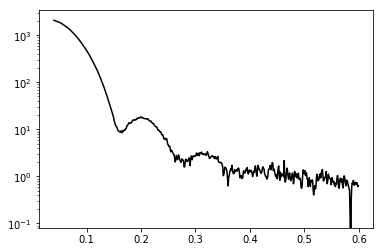

In [4]:
plt.semilogy(q_I[:,0],q_I[:,1],'-k')
plt.show()

#### Step 3. Calculate numerical features (profile) of the spectrum

In [5]:
features = saxs_math.profile_spectrum(q_I)
features

OrderedDict([('Imax_over_Imean', 13.181053776872366),
             ('Imax_sharpness', 1.0200591262893703),
             ('I_fluctuation', 0.001038996426310348),
             ('logI_fluctuation', 5.943073057197209),
             ('logI_max_over_std', 3.2213864774189336),
             ('r_fftIcentroid', 0.10056978331899331),
             ('r_fftImax', 0.0017857142857142857),
             ('q_Icentroid', 0.07198204747458697),
             ('q_logIcentroid', 0.13005159629922175),
             ('pearson_q', -0.5599102444780059),
             ('pearson_q2', -0.4197884860266609),
             ('pearson_expq', -0.5188467663495657),
             ('pearson_invexpq', 0.6012800462298686)])

#### Step 4. Create SaxsCitrination using Citrination credentials

In [6]:
api_key_file = '../../api_key.txt'
saxs_models = CitrinationSaxsModels(api_key_file,'https://slac.citrination.com')

#### Step 5.  Predict scatterer populations

In [7]:
populations, uncertainties = saxs_models.classify(features)
populations

OrderedDict([('unidentified', 0),
             ('guinier_porod', 0),
             ('spherical_normal', 1),
             ('diffraction_peaks', 0)])

In [8]:
uncertainties

OrderedDict([('unidentified', 0.007825454281763955),
             ('guinier_porod', 0.05050983018934078),
             ('spherical_normal', 0.008604491365074463),
             ('diffraction_peaks', 0.006164954858187079)])

The Citrination models predict that the data are identifiable with uncertainty 0.007 and that the scatterers include one population of a normal size distribution of spherical scatterers with uncertainty 0.008. There is not a significant Guinier-Porod-like contribution with uncertainty 0.050 and there are no diffraction peaks with uncertainty 0.006. 

TODO: Briefly explain the uncertainty metric.

#### Step 5. Predict scattering parameters

In [9]:
params,uncertainties = saxs_models.predict_params(populations, features, q_I)
params

OrderedDict([('r0_sphere', [27.928580936639083]),
             ('sigma_sphere', [0.09907383296227086])])

In [10]:
uncertainties

OrderedDict([('r0_sphere', 0.7889737778699067),
             ('sigma_sphere', 0.09215120039782715)])

The Citrination models predict the mean sphere size to be 27.93 + /- 0.79 Angstrom with fractional standard deviation of 0.099 + /- 0.092.

Parameters related to intensity (the intensities of the noise floor and spherical scattering) are now computed by constrained least-squares fitting:

In [11]:
sxf = saxs_fit.SaxsFitter(q_I,populations)
params, report = sxf.fit_intensity_params(params)
params

OrderedDict([('I0_floor', [0.5447869870273797]),
             ('I0_sphere', [3022.9838664690924]),
             ('r0_sphere', [27.928580936639083]),
             ('sigma_sphere', [0.09907383296227086])])

#### Step 6. Evaluate the predicted spectrum

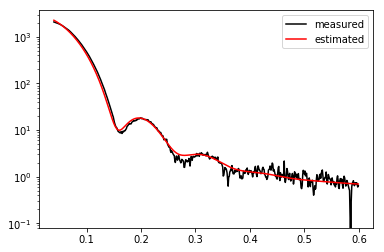

In [12]:
I_estimate = saxs_math.compute_saxs(q_I[:,0],populations,params)
plt.semilogy(q_I[:,0],q_I[:,1],'-k')
plt.semilogy(q_I[:,0],I_estimate,'-r')
plt.legend(['measured','estimated'])
plt.show()

#### Step 7. Least-squares fit the spectrum

In [13]:
params_opt, rpt = sxf.fit(params)
params_opt

OrderedDict([('I0_floor', [0.5395596007862663]),
             ('I0_sphere', [2894.792236592506]),
             ('r0_sphere', [27.693610837117475]),
             ('sigma_sphere', [0.08491358339666427])])

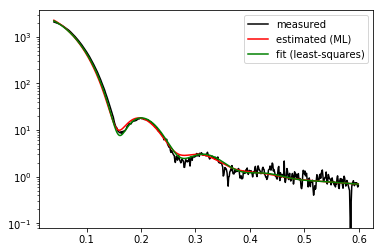

In [14]:
I_opt = saxs_math.compute_saxs(q_I[:,0],populations,params_opt)
plt.semilogy(q_I[:,0],q_I[:,1],'-k')
plt.semilogy(q_I[:,0],I_estimate,'-r')
plt.semilogy(q_I[:,0],I_opt,'-g')
plt.legend(['measured','estimated (ML)','fit (least-squares)'])
plt.show()